# LSTM with stock market data and sentiment

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import os
import sys
import numpy as np
import seaborn as sns
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import src.preprocess_data as preprocess_data

importlib.reload(preprocess_data)

# Set seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Set PyTorch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [72]:
# STOCKS_DATA_PATH = "../data/processed/stocks.csv"
STOCKS_DATA_PATH = "../data/apple_stock/AAPL_1980-12-03_2025-03-15.csv"
# SENTIMENT_DATA_PATH = "../data/processed/sentiment140.csv"
SENTIMENT_DATA_PATH = "../data/sentiment-emotion/sentiment-emotion-labelled_Dell_tweets.csv"

FOCUS_PRICE = "Close"
FOCUS_STOCK = "AAPL"

WINDOW_SIZE = 3
BATCH_SIZE = 16
LEARNING_RATE = 0.01
EPOCHS = 5000

LSTM_HIDDEN_SIZE = 4
LSTM_NUM_LAYERS = 1

## Data Preparation

### Processing

In [73]:
df_stocks = pd.read_csv(STOCKS_DATA_PATH)

df_stocks.columns = ["Date", "Open", "High", "Low", "Close", "AdjClose", "Volume"]


# TODO: Expand this or use tweets from a larger period of time
# df_stocks = df_stocks[df_stocks["Name"] == FOCUS_STOCK]
# df_stocks = df_stocks[:1000]

df_stocks = df_stocks[["Date", FOCUS_PRICE]]

# df_stocks[FOCUS_PRICE] = (df_stocks[FOCUS_PRICE] - df_stocks[FOCUS_PRICE].min()) / (df_stocks[FOCUS_PRICE].max() - df_stocks[FOCUS_PRICE].min())
df_stocks[FOCUS_PRICE] = (df_stocks[FOCUS_PRICE] - df_stocks[FOCUS_PRICE].mean()) / df_stocks[FOCUS_PRICE].std()

df_stocks["Date"] = df_stocks["Date"].apply(lambda x: x.split(" ")[0])
df_stocks["Date"] = df_stocks["Date"].apply(preprocess_data.convert_date)

df_stocks.set_index("Date", inplace=True)

df_stocks = preprocess_data.apply_time_window(df = df_stocks,
                                              price_col_name=FOCUS_PRICE,
                                              n = WINDOW_SIZE)

print(len(df_stocks))
display(df_stocks.head(10))

11151


,Close,Close-3,Close-2,Close-1
Date,,,,
1980-12-17,-0.483888,-0.483641,-0.483770,-0.483942
1980-12-18,-0.483823,-0.483770,-0.483942,-0.483888
1980-12-19,-0.483684,-0.483942,-0.483888,-0.483823
1980-12-22,-0.483565,-0.483888,-0.483823,-0.483684
1980-12-23,-0.483458,-0.483823,-0.483684,-0.483565
1980-12-24,-0.483318,-0.483684,-0.483565,-0.483458
1980-12-26,-0.483060,-0.483565,-0.483458,-0.483318
1980-12-29,-0.483017,-0.483458,-0.483318,-0.483060
1980-12-30,-0.483093,-0.483318,-0.483060,-0.483017


In [74]:
df_sentiment = pd.read_csv(SENTIMENT_DATA_PATH)

df_sentiment["Datetime"] = pd.to_datetime(df_sentiment["Datetime"])
df_sentiment["Day"] = df_sentiment["Datetime"].dt.date

sentiment_map = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
}

df_sentiment["sentiment"] = df_sentiment["sentiment"].map(sentiment_map).astype(float)
mask = df_sentiment["Text"].str.lower().str.contains(r"\b(apple|iphone|imac|macbook)\b", na=False)
df_sentiment.loc[mask, "sentiment"] *= 10

mask = df_sentiment["Text"].str.lower().str.contains(r"\b(finance|stock|market|etf|price)\b", na=False)
df_sentiment.loc[mask, "sentiment"] *= 5

# df_sentiment.loc[mask, "sentiment"] /= 5000


daily_sentiment = df_sentiment.groupby("Day")["sentiment"].mean().reset_index()
daily_sentiment.columns = ["date", "average_sentiment"]

daily_sentiment['average_sentiment'] = daily_sentiment['average_sentiment'].rolling(window=10, center=True).mean()

daily_sentiment.set_index("date", inplace=True)

daily_sentiment = preprocess_data.apply_time_window(df = daily_sentiment,
                                                    price_col_name = "average_sentiment",
                                                    n = WINDOW_SIZE)

daily_sentiment.head()

/var/folders/y1/8gpcgrm115b0n205_p4s1wvw0000gn/T/ipykernel_39294/3200339065.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_sentiment["Text"].str.lower().str.contains(r"\b(apple|iphone|imac|macbook)\b", na=False)
/var/folders/y1/8gpcgrm115b0n205_p4s1wvw0000gn/T/ipykernel_39294/3200339065.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_sentiment["Text"].str.lower().str.contains(r"\b(finance|stock|market|etf|price)\b", na=False)


,average_sentiment,average_sentiment-3,average_sentiment-2,average_sentiment-1
date,,,,
2022-01-09,-0.288141,-0.248510,-0.349411,-0.364666
2022-01-10,-0.254033,-0.349411,-0.364666,-0.288141
2022-01-11,-0.308833,-0.364666,-0.288141,-0.254033
2022-01-12,-0.297376,-0.288141,-0.254033,-0.308833
2022-01-13,-0.358426,-0.254033,-0.308833,-0.297376


In [ ]:
# df_sentiment = pd.read_csv(SENTIMENT_DATA_PATH)

# df_sentiment["Datetime"] = pd.to_datetime(df_sentiment["Datetime"])
# df_sentiment["Day"] = df_sentiment["Datetime"].dt.date
# daily_sentiment = df_sentiment.groupby("Day")["sentiment_score"].mean().reset_index()
# daily_sentiment.columns = ["date", "average_sentiment"]
# # daily_sentiment['average_sentiment'] = daily_sentiment['average_sentiment'].rolling(window=20, center=True).mean()
# daily_sentiment.set_index("date", inplace=True)

# daily_sentiment.head()

,average_sentiment
date,
2022-01-01,NaN
2022-01-02,NaN
2022-01-03,NaN
2022-01-04,NaN
2022-01-05,NaN


In [ ]:
# df_sentiment = pd.read_csv(SENTIMENT_DATA_PATH)

# df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
# df_sentiment['day'] = df_sentiment['date'].dt.date
# daily_sentiment = df_sentiment.groupby('day')['target'].mean().reset_index()
# daily_sentiment.columns = ['date', 'average_sentiment']
# daily_sentiment.set_index("date", inplace=True)

# print(len(daily_sentiment))
# display(daily_sentiment.head(10))

48


,average_sentiment
date,
2009-04-06,2.302922
2009-04-07,2.348545
2009-04-17,2.386636
2009-04-18,2.338119
2009-04-19,2.336456
2009-04-20,2.306624
2009-04-21,2.368108
2009-05-01,2.313441
2009-05-02,2.338515


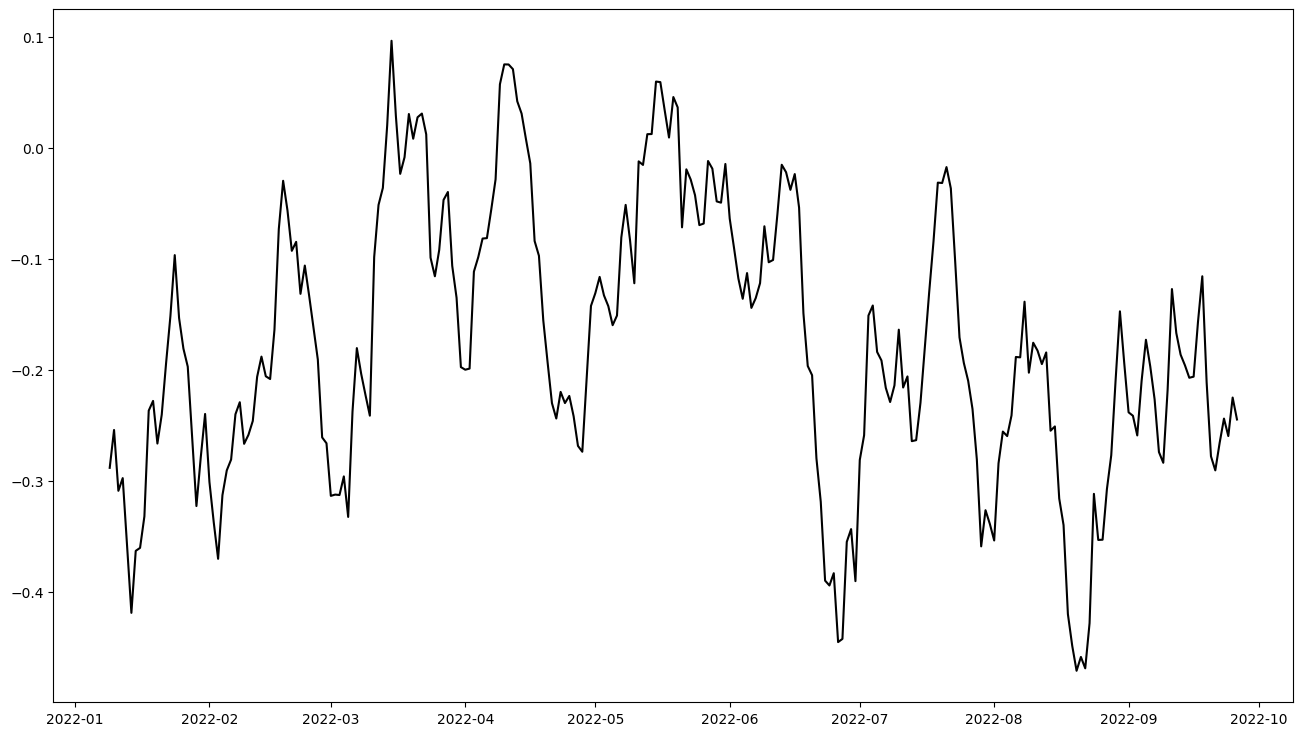

In [75]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(daily_sentiment["average_sentiment"], color="black")

In [76]:
df = pd.merge(df_stocks, daily_sentiment, how="left", left_index=True, right_index=True)
df["average_sentiment"] = df["average_sentiment"].shift(1)
display(df.head())
print(len(df))

,Close,Close-3,Close-2,Close-1,average_sentiment,average_sentiment-3,average_sentiment-2,average_sentiment-1
Date,,,,,,,,
1980-12-17,-0.483888,-0.483641,-0.483770,-0.483942,NaN,NaN,NaN,NaN
1980-12-18,-0.483823,-0.483770,-0.483942,-0.483888,NaN,NaN,NaN,NaN
1980-12-19,-0.483684,-0.483942,-0.483888,-0.483823,NaN,NaN,NaN,NaN
1980-12-22,-0.483565,-0.483888,-0.483823,-0.483684,NaN,NaN,NaN,NaN
1980-12-23,-0.483458,-0.483823,-0.483684,-0.483565,NaN,NaN,NaN,NaN


11151


In [77]:
# df["average_sentiment"] = df["average_sentiment"].fillna(0.5)
df = df[df["average_sentiment"].notna()]
for i in range(1, WINDOW_SIZE + 1):
    df = df[df[f"average_sentiment-{i}"].notna()]
print(len(df))

178


In [78]:
print(df.head())

               Close   Close-3   Close-2   Close-1  average_sentiment  \
Date                                                                    
2022-01-11  2.885603  2.826288  2.829562  2.829947          -0.254033   
2022-01-12  2.894269  2.829562  2.829947  2.885603          -0.308833   
2022-01-13  2.829947  2.829947  2.885603  2.894269          -0.297376   
2022-01-14  2.846894  2.885603  2.894269  2.829947          -0.358426   
2022-01-18  2.783920  2.894269  2.829947  2.846894          -0.418773   

            average_sentiment-3  average_sentiment-2  average_sentiment-1  
Date                                                                       
2022-01-11            -0.364666            -0.288141            -0.254033  
2022-01-12            -0.288141            -0.254033            -0.308833  
2022-01-13            -0.254033            -0.308833            -0.297376  
2022-01-14            -0.308833            -0.297376            -0.358426  
2022-01-18            -0.362933 

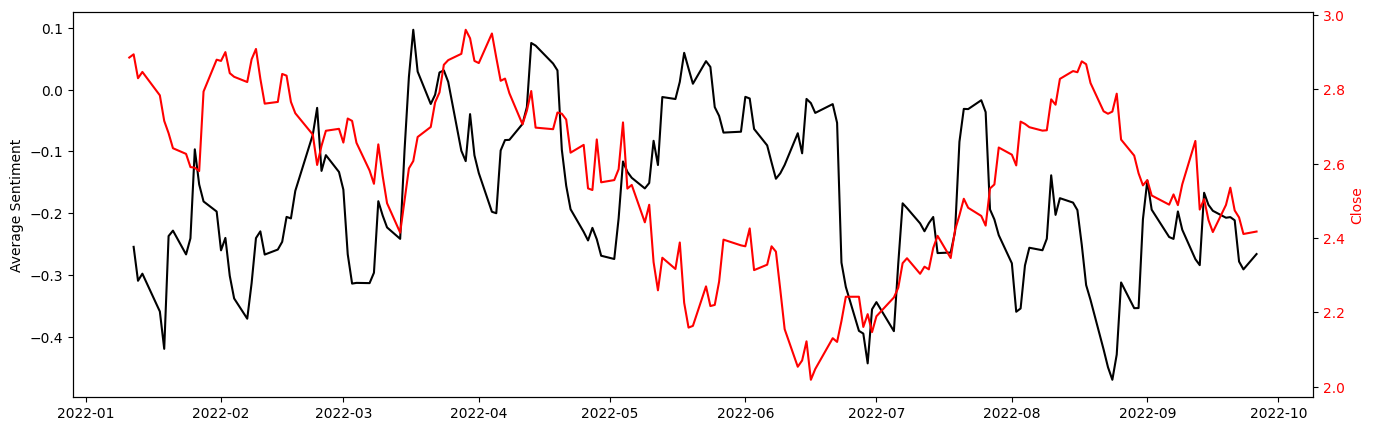

In [79]:
fig, ax1 = plt.subplots(figsize=(16, 5))

df_ = df.copy()
df_["average_sentiment"] = df_["average_sentiment"].shift(1)

ax1.plot(df_["average_sentiment"], color="black", label="Average sentiment")
ax1.set_ylabel("Average Sentiment", color="black")
ax1.tick_params(axis='y', labelcolor="black")

ax2 = ax1.twinx()

ax2.plot(df_[FOCUS_PRICE], color="red", label=FOCUS_PRICE)
ax2.set_ylabel(FOCUS_PRICE, color="red")
ax2.tick_params(axis='y', labelcolor="red")

plt.show()

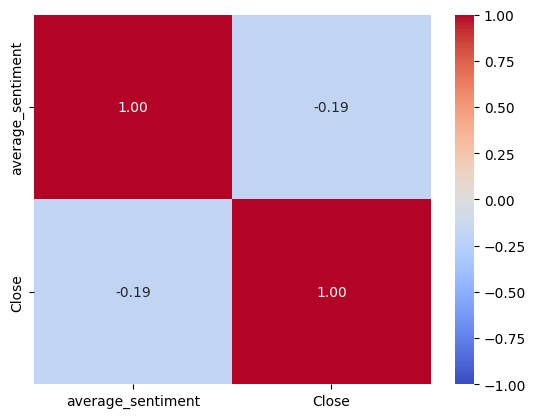

In [80]:
corr = df[["average_sentiment", FOCUS_PRICE]].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.show()

In [81]:
df.head()

,Close,Close-3,Close-2,Close-1,average_sentiment,average_sentiment-3,average_sentiment-2,average_sentiment-1
Date,,,,,,,,
2022-01-11,2.885603,2.826288,2.829562,2.829947,-0.254033,-0.364666,-0.288141,-0.254033
2022-01-12,2.894269,2.829562,2.829947,2.885603,-0.308833,-0.288141,-0.254033,-0.308833
2022-01-13,2.829947,2.829947,2.885603,2.894269,-0.297376,-0.254033,-0.308833,-0.297376
2022-01-14,2.846894,2.885603,2.894269,2.829947,-0.358426,-0.308833,-0.297376,-0.358426
2022-01-18,2.783920,2.894269,2.829947,2.846894,-0.418773,-0.362933,-0.360240,-0.331842


### Conversion to PyTorch, data splitting

In [82]:
if "average_sentiment" in df.columns:
    df = df.drop(columns=["average_sentiment"])

Xy = df.to_numpy()
X = Xy[:, 1:]
# X = np.expand_dims(X, axis=-1)
X = np.stack((X[:, :WINDOW_SIZE], X[:, WINDOW_SIZE:]), axis=2)

y = Xy[:, :1]

print(X.shape, y.shape)

(178, 3, 2) (178, 1)


In [ ]:
# scaler_x = MinMaxScaler()
# scaler_y = MinMaxScaler()

# X = scaler_x.fit_transform(X.reshape(-1, X.shape[-2])).reshape(X.shape)
# y = scaler_y.fit_transform(y)

In [83]:
split = int(len(X) * 0.8)

X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([142, 3, 2]) torch.Size([142, 1])
torch.Size([36, 3, 2]) torch.Size([36, 1])


### Dataset and DataLoaders

In [84]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(X)

    def __len__(self):
        return self.len
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [85]:
train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Modelling

### Model

In [86]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, sentiment):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        
        self.sentiment_mlp = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

        if sentiment:
            self.fc = nn.Linear(hidden_size, 1)
        else:
            self.fc = nn.Linear(hidden_size, 1)

        self.sentiment = sentiment

    def forward(self, x):
        batch_size = x.size(0)

        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        # x_lstm = x[:, :-1, :]

        if self.sentiment:
            # x_sentiment = x[:, -1, :]

            x, _ = self.lstm(x, (h_0, c_0))

            x = x[:, -1, :]
            # x_sentiment = self.sentiment_mlp(x_sentiment)

            # x = x_
            # x = torch.cat((x_lstm[:, -1, :], x_sentiment[:, -1].unsqueeze(1)), dim=1)
        else:
            # x = x[:, :WINDOW_SIZE, :]

            x, _ = self.lstm(x, (h_0, c_0))
            x = x[:, -1, :]

        x = self.fc(x)
        
        return x

### Training

In [87]:
def train_model(sentiment=False):
    np.random.seed(0)
    torch.manual_seed(0)

    if sentiment:
        input_size = 2
    else:
        input_size = 1

    model = LSTM(input_size=input_size,
             hidden_size=LSTM_HIDDEN_SIZE,
             num_layers=LSTM_NUM_LAYERS,
             sentiment=sentiment).to(device)

    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=LEARNING_RATE)

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(EPOCHS):
        model.train(True)

        train_loss = 0
        cnt = 0
        for i, batch in enumerate(train_dataloader):
            X, y = batch[0].to(device), batch[1].to(device)

            if not sentiment:
                X = X[:, :, 0:1]

            out = model(X)
            l = loss(out, y)
            train_loss += l.item()

            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            cnt += 1

        train_loss /= cnt

        model.train(False)

        val_loss = 0
        cnt = 0
        for i, batch in enumerate(test_dataloader):
            X, y = batch[0].to(device), batch[1].to(device)

            if not sentiment:
                X = X[:, :, 0:1]

            with torch.no_grad():
                out = model(X)
                l = loss(out, y)

                val_loss += l.item()

            cnt += 1

        val_loss /= cnt

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

        if epoch % 100 == 0:
            print(f"[ Epoch {epoch} / {EPOCHS} ] Train loss = {train_loss} Val loss = {val_loss}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Best val loss: {best_val_loss}")

    return model

In [89]:
model_no_sentiment = train_model(sentiment=False)

[ Epoch 0 / 5000 ] Train loss = 8.837869114345974 Val loss = 7.950729052225749
[ Epoch 100 / 5000 ] Train loss = 0.004956417251378298 Val loss = 0.0044742476505537825
[ Epoch 200 / 5000 ] Train loss = 0.0049219681984848445 Val loss = 0.002662135132898887
[ Epoch 300 / 5000 ] Train loss = 0.0045630374354206854 Val loss = 0.0030374090808133283
[ Epoch 400 / 5000 ] Train loss = 0.004996430904914935 Val loss = 0.003606111742556095
[ Epoch 500 / 5000 ] Train loss = 0.004467722364804811 Val loss = 0.0035662810939053693
[ Epoch 600 / 5000 ] Train loss = 0.004443268834923704 Val loss = 0.002807745166743795
[ Epoch 700 / 5000 ] Train loss = 0.004637857045357426 Val loss = 0.0034310468666565916
[ Epoch 800 / 5000 ] Train loss = 0.005071111825398273 Val loss = 0.003979153543089827
[ Epoch 900 / 5000 ] Train loss = 0.0046359035186469555 Val loss = 0.005459486894930403
[ Epoch 1000 / 5000 ] Train loss = 0.0043602071624870105 Val loss = 0.0028625852428376675
[ Epoch 1100 / 5000 ] Train loss = 0.0052

In [88]:
model_sentiment = train_model(sentiment=True)

[ Epoch 0 / 5000 ] Train loss = 7.570615980360243 Val loss = 7.10899559656779
[ Epoch 100 / 5000 ] Train loss = 0.006743718507803149 Val loss = 0.0063184980147828656
[ Epoch 200 / 5000 ] Train loss = 0.004887120384309027 Val loss = 0.0029016852301235
[ Epoch 300 / 5000 ] Train loss = 0.006655313462639849 Val loss = 0.0033701021069039903
[ Epoch 400 / 5000 ] Train loss = 0.004899638963656293 Val loss = 0.002937212741623322
[ Epoch 500 / 5000 ] Train loss = 0.005322986541108953 Val loss = 0.0027587892254814506
[ Epoch 600 / 5000 ] Train loss = 0.004439065336353249 Val loss = 0.00271340556597958
[ Epoch 700 / 5000 ] Train loss = 0.004916756388006939 Val loss = 0.0053444661510487395
[ Epoch 800 / 5000 ] Train loss = 0.005093173201506336 Val loss = 0.00308392154208074
[ Epoch 900 / 5000 ] Train loss = 0.004730027246599396 Val loss = 0.0028056608280166984
[ Epoch 1000 / 5000 ] Train loss = 0.004344033323124879 Val loss = 0.0033885794691741467
[ Epoch 1100 / 5000 ] Train loss = 0.005066380034

## Evaluation

In [100]:
def eval_model(model, sentiment):
    with torch.no_grad():
        if not sentiment:
            X_train_ = X_train[:, :, 0:1]
            X_test_ = X_test[:, :, 0:1]
        else:
            X_train_ = X_train
            X_test_ = X_test
        y_train_pred = model(X_train_.to(device)).to("cpu")
        y_train_pred = np.array(y_train_pred)

        y_test_pred = model(X_test_.to(device)).to("cpu")
        y_test_pred = np.array(y_test_pred)

    return y_train_pred, y_test_pred

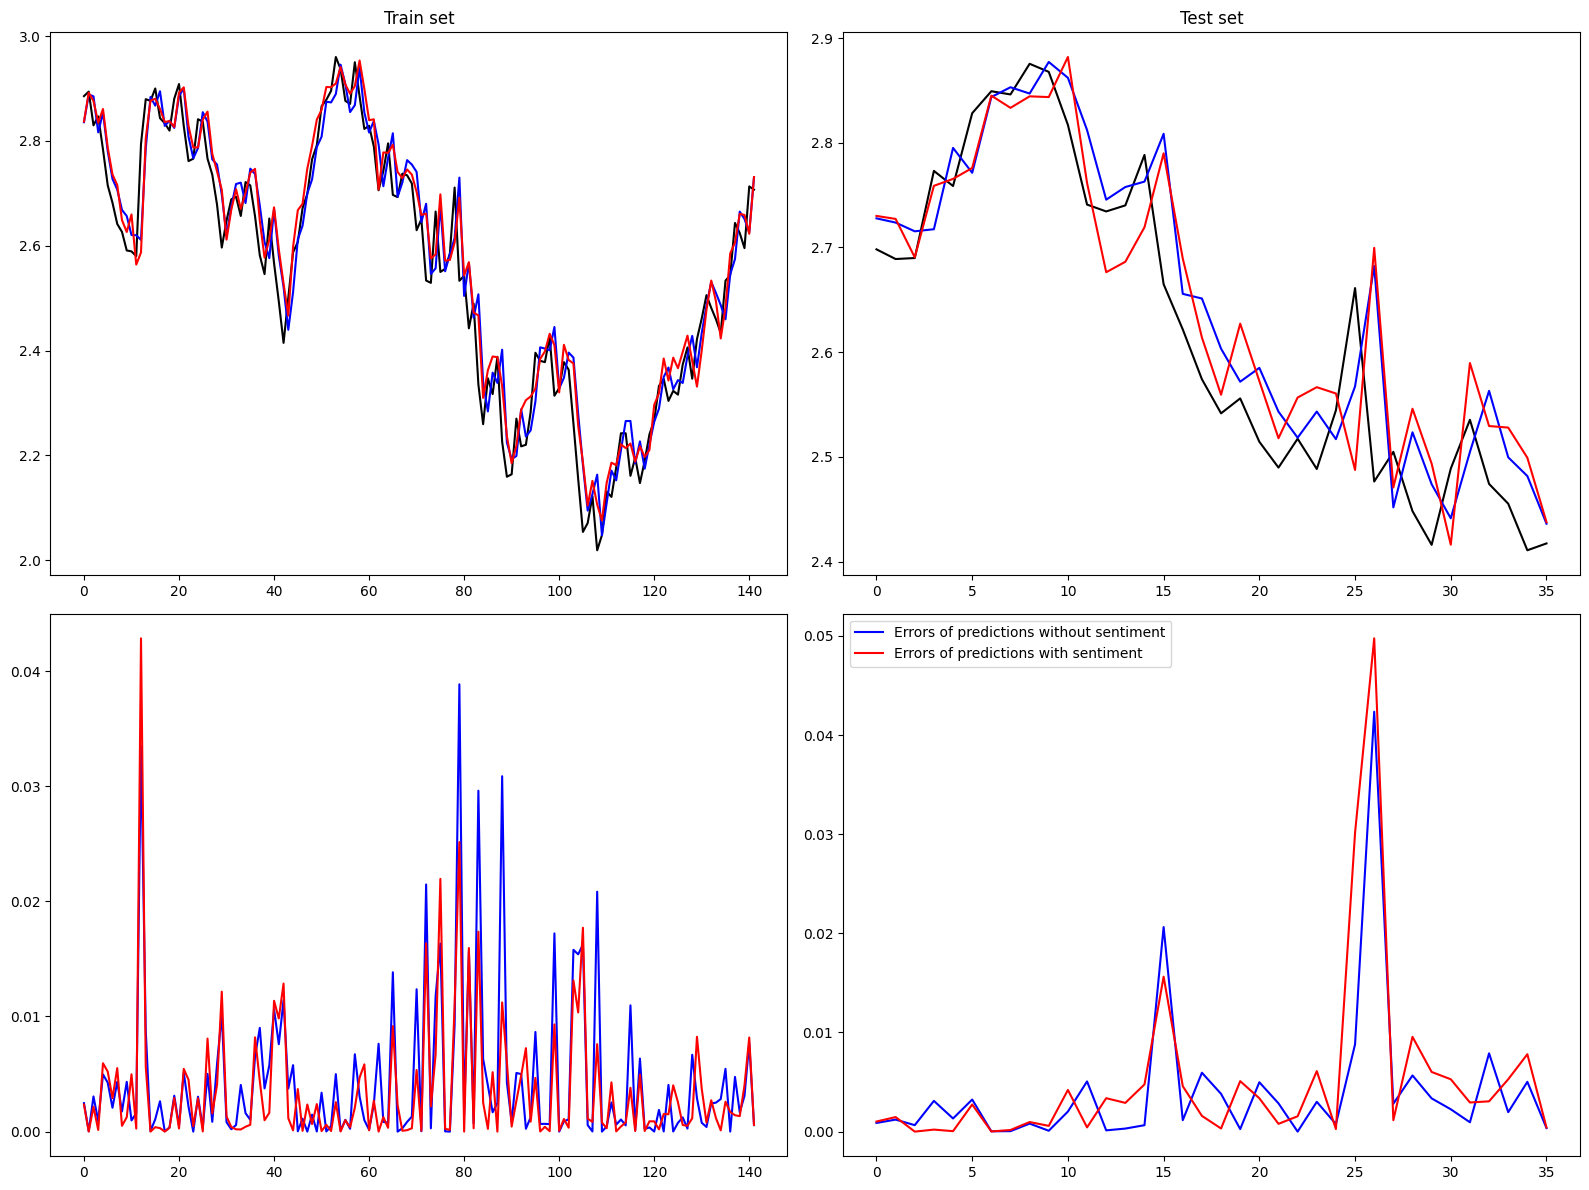

In [101]:
y_train_pred_no_sentiment, y_test_pred_no_sentiment = eval_model(model_no_sentiment, sentiment=False)
y_train_pred_sentiment, y_test_pred_sentiment = eval_model(model_sentiment, sentiment=True)

fig, ax = plt.subplots(2, 2, figsize=(16, 12))

ax[0, 0].plot(y_train, color="black", label = "True")
ax[0, 0].plot(y_train_pred_no_sentiment, color="blue", label = "Predictions without sentiment")
ax[0, 0].plot(y_train_pred_sentiment, color="red", label = "Predictions with sentiment")
ax[0, 0].set_title("Train set")

ax[0, 1].plot(y_test, color="black", label = "True")
ax[0, 1].plot(y_test_pred_no_sentiment, color="blue", label = "Predictions without sentiment")
ax[0, 1].plot(y_test_pred_sentiment, color="red", label = "Predictions with sentiment")
ax[0, 1].set_title("Test set")

ax[1, 0].plot((y_train_pred_no_sentiment - y_train.numpy()) ** 2, color="blue", label = "Errors of predictions without sentiment")
ax[1, 0].plot((y_train_pred_sentiment - y_train.numpy()) ** 2, color="red", label = "Errors of predictions with sentiment")

ax[1, 1].plot((y_test_pred_no_sentiment - y_test.numpy()) ** 2, color="blue", label = "Errors of predictions without sentiment")
ax[1, 1].plot((y_test_pred_sentiment - y_test.numpy()) ** 2, color="red", label = "Errors of predictions with sentiment")

plt.legend()
plt.tight_layout()

# TODO: Comparison sentiment vs no sentiment
# TODO: Another lstm for sentiment?
# TODO: Same lstm for sentiment?

# TODO: More weight to sentiments of tweets that contain Apple keywords
# TODO: Take sentiments from the previous few days, not the current day
# TODO: Convolutional NN for feature extraction